# Temporal Segmentations.

The goal is to classify crude oil data streams based on 30-minute intervals using signature features, demonstrating the method’s applicability in temporal segmentation tasks.

In [1]:
import pandas as pd
import esig.tosig as ts
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

## Data Obtention

In [2]:
# Define the column names
column_names = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

# Read the CSV files without headers, using ';' as the delimiter
df_2021 = pd.read_csv('DAT_ASCII_WTIUSD_M1_2021.csv', delimiter=';', header=None, names=column_names)
df_2022 = pd.read_csv('DAT_ASCII_WTIUSD_M1_2022.csv', delimiter=';', header=None, names=column_names)
df_2023 = pd.read_csv('DAT_ASCII_WTIUSD_M1_2023.csv', delimiter=';', header=None, names=column_names)

# Combine the DataFrames into a single one
df_combined = pd.concat([df_2021, df_2022, df_2023])

# Reset the indices of the combined DataFrame
df_combined.reset_index(drop=True, inplace=True)

print("Files combined and successfully saved in 'DAT_ASCII_WTIUSD_M1_combined.csv'")

# Convert 'Timestamp' column to datetime format
df_combined['Timestamp'] = pd.to_datetime(df_combined['Timestamp'], format='%Y%m%d %H%M%S')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_combined.iloc[:5000])


Files combined and successfully saved in 'DAT_ASCII_WTIUSD_M1_combined.csv'
               Timestamp    Open    High     Low   Close  Volume
0    2021-01-03 18:00:00  48.208  48.208  48.103  48.148       0
1    2021-01-03 18:01:00  48.133  48.278  48.133  48.218       0
2    2021-01-03 18:02:00  48.238  48.238  48.153  48.188       0
3    2021-01-03 18:03:00  48.208  48.213  48.183  48.183       0
4    2021-01-03 18:04:00  48.188  48.198  48.173  48.188       0
5    2021-01-03 18:05:00  48.193  48.283  48.193  48.283       0
6    2021-01-03 18:06:00  48.278  48.313  48.253  48.253       0
7    2021-01-03 18:07:00  48.243  48.293  48.243  48.283       0
8    2021-01-03 18:08:00  48.273  48.338  48.273  48.338       0
9    2021-01-03 18:09:00  48.343  48.353  48.323  48.333       0
10   2021-01-03 18:10:00  48.337  48.353  48.313  48.318       0
11   2021-01-03 18:11:00  48.323  48.333  48.318  48.333       0
12   2021-01-03 18:12:00  48.337  48.413  48.337  48.413       0
13   2021-01-0

In [3]:
df_combined.drop(columns=['Volume'], inplace=True)

## Data Preprocess, Model and Evaluation functions

In [4]:
def filter_and_create_data_streams(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined):
    """
    Filters the dataframe for specific time intervals and creates data streams.

    Args:
        time1_h (int): The hour for the first time interval.
        time1_min_start (int): The start minute for the first time interval.
        time1_min_finish (int): The end minute for the first time interval.
        time2_h (int): The hour for the second time interval.
        time2_min_start (int): The start minute for the second time interval.
        time2_min_finish (int): The end minute for the second time interval.
        df_combined (pd.DataFrame): The combined dataframe with data from several years.

    Returns:
        list: A list of data streams, where each data stream is a dataframe containing rows 
              from the specified time intervals.
    """
    # Filter the rows that contain the specific hours
    filtered_df = df_combined[((df_combined['Timestamp'].dt.hour == time1_h) &
                               (df_combined['Timestamp'].dt.minute <= time1_min_finish) &
                               (df_combined['Timestamp'].dt.minute >= time1_min_start)) |
                               ((df_combined['Timestamp'].dt.hour == time2_h) & 
                               (df_combined['Timestamp'].dt.minute >= time2_min_start) & 
                               (df_combined['Timestamp'].dt.minute <= time2_min_finish))]

    # Initialize the list of data streams
    data_streams = []
    
    # Initialize the index to track the start of each data stream
    start_index = None
    
    # Iterate over the filtered rows
    for index, row in filtered_df.iterrows():
        # Check if the time is one of the starting ones
        if (row['Timestamp'].hour == time1_h and row['Timestamp'].minute == time1_min_start) or (row['Timestamp'].hour == time2_h and row['Timestamp'].minute == time2_min_start):
            # If it's the start of a new data stream, update the start index
            start_index = index
        # Check if the time is finishes when it should
        elif (row['Timestamp'].hour == time1_h and row['Timestamp'].minute == time1_min_finish) or (row['Timestamp'].hour == time2_h and row['Timestamp'].minute == time2_min_finish):
            # If it's the end of a data stream, save the data stream from the start index to the current index (inclusive)
            data_streams.append(df_combined.loc[start_index:index])
            # Reset the start index for the next data stream
            start_index = None
    
    # Ensure to add the last data stream if it hasn't been added yet
    if start_index is not None:
        data_streams.append(df_combined.loc[start_index:])

    # Now data_streams will contain the data streams needed, each with a maximum of 30 rows.
    return data_streams

def classify_data_streams(time1_h, time1_min_start, time2_h, time2_min_start, data_streams):
    """
    Classifies the data streams into two categories based on the start time.

    Args:
        time1_h (int): The hour for the first category.
        time1_min_start (int): The start minute for the first category.
        time2_h (int): The hour for the second category.
        time2_min_start (int): The start minute for the second category.
        data_streams (list): A list of data streams to be classified.

    Returns:
        tuple: Two lists containing data streams starting at the specified times.
    """
    # Define two lists to store the data streams 
    data_streams_time1 = []
    data_streams_time2 = []

    # Iterate over the data streams
    for data_stream in data_streams:
        # Create a copy of the data stream to avoid the SettingWithCopyWarning
        data_stream = data_stream.copy()
        # Check if the data stream starts at time1
        if data_stream.iloc[0]['Timestamp'].hour == time1_h and data_stream.iloc[0]['Timestamp'].minute == time1_min_start:
            data_streams_time1.append(data_stream)
        # Check if the data stream starts at time2
        elif data_stream.iloc[0]['Timestamp'].hour == time2_h and data_stream.iloc[0]['Timestamp'].minute == time2_min_start:
            data_streams_time2.append(data_stream)

    return data_streams_time1, data_streams_time2

def normalize_time(timestamps):
    """
    Normalize timestamps relative to the first timestamp in the series.

    Args:
        timestamps: Series of timestamps.

    Returns:
        pd.Series: Normalized timestamps.
    """
    return (timestamps - timestamps.iloc[0]) / (timestamps.iloc[-1] - timestamps.iloc[0])



def transform_data(df_list):
    """
    Transform the data in the list of DataFrames.

    Args:
        df_list (list): List of DataFrames.

    Returns:
        list: List of transformed DataFrames.
    """
    transformed_dfs = []
    for df in df_list:
        # Make a copy of the DataFrame to avoid modifying the original
        df_copy = df.copy()

        # Calculate normalized columns
        df_copy['Normalized_time'] = normalize_time(df_copy['Timestamp'])
        df_copy['Open_Normalized'] = (df_copy['Open'] - df_copy['Open'].mean()) / df_copy['Open'].std()
        df_copy['High_Normalized'] = (df_copy['High'] - df_copy['High'].mean()) / df_copy['High'].std()
        df_copy['Low_Normalized'] = (df_copy['Low'] - df_copy['Low'].mean()) / df_copy['Low'].std()
        df_copy['Close_Normalized'] = (df_copy['Close'] - df_copy['Close'].mean()) / df_copy['Close'].std()

        # Calculate the logarithm of the mid price
        df_copy['Log_Mid_Price'] = np.log((df_copy['High'] + df_copy['Low']) / 2)

        # Calculate the standardized spread
        df_copy['Spread'] = df_copy['High'] - df_copy['Low']
        df_copy['Standardized_Spread'] = (df_copy['Spread'] - df_copy['Spread'].mean()) / df_copy['Spread'].std()

        # Drop the original columns
        df_copy.drop(columns=['Open', 'High', 'Low', 'Close', 'Spread', 'Timestamp'], inplace=True)

        transformed_dfs.append(df_copy)
    return transformed_dfs

def lead_lag_transform(df_list):
    """
    Perform lead and lag transformations on the specified DataFrame.

    Args:
        df (DataFrame): The DataFrame to be transformed.

    Returns:
        DataFrame: The transformed DataFrame.
    """
    transformed_dfs = []
    #'High_Normalized', 'Low_Normalized'
    lead_cols = ['Normalized_time','Open_Normalized', 'Close_Normalized', 'Log_Mid_Price', 'Standardized_Spread']
    lag_cols = ['Log_Mid_Price']
    
    for df in df_list:
        transformed_df = df.copy()
        
        # Perform lead transformation
        for col in lead_cols:
            transformed_df[f"{col}_Lead"] = transformed_df[col].shift(-1)

        # Perform lag transformation
        for col in lag_cols:
            transformed_df[f"{col}_Lag"] = transformed_df[col].shift(1)

        # Remove the first and last rows which contain NaN values due to transformation
        transformed_df = transformed_df.iloc[1:-1]
        
        transformed_dfs.append(transformed_df)
    
    return transformed_dfs


def compute_signature(stream, order):
    """
    Compute the signature of a given stream up to the specified order.

    Args:
        stream (list or array-like): The input data stream.
        order (int): The order of the signature.

    Returns:
        array: The computed signature.
    """
    # Convert the stream to a numpy array
    stream_array = pd.DataFrame(stream).values
    # Compute the signature up to the specified order
    signature = ts.stream2sig(stream_array, order)
    return signature

def signatures(data_streams, order):
    """
    Compute the signature for each stream in the list up to the specified order.

    Args:
        data_streams (list): List of input data streams.
        order (int): The order of the signature.

    Returns:
        DataFrame: DataFrame containing the computed signatures.
    """
    signatures = []
    # Compute the signature for each stream in the list
    signatures = [compute_signature(stream, order) for stream in data_streams]
    
    
    # Convert the list of signatures to a DataFrame for better visualization
    signatures_df = pd.DataFrame(signatures)
    return signatures_df
 

def prepare_data_to_classificate(signatures_time1, signatures_time2):
    """
    Prepare the data for classification by creating train and test sets and adding the labels.

    Args:
        signatures_time1 (DataFrame): DataFrame containing signatures for time 1.
        signatures_time2 (DataFrame): DataFrame containing signatures for time 2.

    Returns:
        tuple: A tuple containing train and test data DataFrames.
    """
    # Assuming you have signatures_df_1630 and signatures_df_1030 DataFrames
    
    # Add a column 'y' with value 1 for signatures_df_1630 and 0 for signatures_df_1030
    signatures_time1['y'] = 1
    signatures_time2['y'] = 0
    
    # Concatenate the two DataFrames
    combined_data = pd.concat([signatures_time1, signatures_time2], ignore_index=True)
    
    # Shuffle the combined DataFrame
    combined_data_shuffled = combined_data.sample(frac=1, random_state=42)
    
    # Split the shuffled DataFrame into train and test sets while maintaining the same proportion of data from each group
    np.random.seed(3)
    train_data, test_data = train_test_split(combined_data_shuffled, test_size=0.25, stratify=combined_data_shuffled['y'], random_state=42)
    
    # Display the shapes of train and test sets to verify proportions
    print("Train data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)
    
    
    return train_data, test_data

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.exceptions import ConvergenceWarning
import warnings

def model(train_data, test_data, n_folds=5):
    """
    Perform classification modeling including training, testing, and evaluation.

    Args:
        train_data (DataFrame): Training data containing features and target variable.
        test_data (DataFrame): Testing data containing features and target variable.

    Returns:
        None
    """
    # Reset model to clear previous information
    lasso_model = None
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data.drop(columns=['y']))
    X_test_scaled = scaler.transform(test_data.drop(columns=['y']))
    
    # Separate features and target variable in the train set
    y_train = train_data['y'].values  # Ensure these are numpy arrays
    y_test = test_data['y'].values  # Ensure these are numpy arrays
   
    # Initialize Lasso regression model
    lasso_model = Lasso(alpha=0.01)  # Adjust the alpha value as needed
   
    # Fit the model on the training data
    lasso_model.fit(X_train_scaled, y_train)
    
    # Predict on the train set
    y_train_pred = lasso_model.predict(X_train_scaled)
    
    # Predict on the test set
    y_test_pred = lasso_model.predict(X_test_scaled)

    ###########
    # Identify the two most relevant features
    feature_names = train_data.drop(columns=['y']).columns
    lasso_coefficients = lasso_model.coef_
    sorted_indices = np.argsort(np.abs(lasso_coefficients))[::-1]
    top_two_features = feature_names[sorted_indices[:2]]
    
    # Plot the two most relevant features
    plt.figure(figsize=(10, 6))
    
    plt.scatter(X_train_scaled[y_train == 0, sorted_indices[0]], X_train_scaled[y_train == 0, sorted_indices[1]], color='blue', label='Class 0', alpha=0.6, edgecolor='k')
    plt.scatter(X_train_scaled[y_train == 1, sorted_indices[0]], X_train_scaled[y_train == 1, sorted_indices[1]], color='red', label='Class 1', alpha=0.6, edgecolor='k')
    
    plt.xlabel(top_two_features[0])
    plt.ylabel(top_two_features[1])
    plt.title('Top Two Features by Lasso Coefficients')
    plt.legend()
    plt.colorbar(label='Target variable')
    plt.show()
    ##########
    
    
    # Compute KS distance and ROC AUC for training set
    ks_train, roc_auc_train = evaluate_ks_and_roc_auc(y_train, y_train_pred)
    print("Kolmogorov-Smirnov Distance (Training):", ks_train)
    print("ROC AUC (Training):", roc_auc_train)
    
    # Compute KS distance and ROC AUC for testing set
    ks_test, roc_auc_test = evaluate_ks_and_roc_auc(y_test, y_test_pred)
    print("Kolmogorov-Smirnov Distance (Testing):", ks_test)
    print("ROC AUC (Testing):", roc_auc_test)
    
    # Set the decision boundary at the level where the KS distance is attained
    threshold = 0.5  # Placeholder, you should set this based on your criteria
    print("Decision Boundary Threshold:", threshold)
    
    # Compute confusion matrix and accuracy for training set
    y_train_pred_binary = (y_train_pred >= threshold).astype(int)
    train_confusion_matrix = confusion_matrix(y_train, y_train_pred_binary)
    train_accuracy = accuracy_score(y_train, y_train_pred_binary)
    print("Train Accuracy:", train_accuracy)
    print("Confusion Matrix (Training):\n", train_confusion_matrix)
    
    # Compute confusion matrix and accuracy for testing set
    y_test_pred_binary = (y_test_pred >= threshold).astype(int)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred_binary)
    test_accuracy = accuracy_score(y_test, y_test_pred_binary)
    print("Test Accuracy:", test_accuracy)
    print("Confusion Matrix (Testing):\n", test_confusion_matrix)
    
    # Ratio of correct classifications
    train_correct_classifications_ratio = train_accuracy
    test_correct_classifications_ratio = test_accuracy
    print("Ratio of Correct Classifications (Training):", train_correct_classifications_ratio)
    print("Ratio of Correct Classifications (Testing):", test_correct_classifications_ratio)
    
    
    # Plot ROC curve for training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label='ROC Curve (Training) (AUC = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve (Training)')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot ROC curve for testing set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test, tpr_test, label='ROC Curve (Testing) (AUC = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve (Testing)')
    plt.legend(loc="lower right")
    plt.show()


# code by https://towardsdatascience.com/evaluating-classification-models-with-kolmogorov-smirnov-ks-test-e211025f5573
def evaluate_ks_and_roc_auc(y_real, y_proba):
    """
    Evaluate the Kolmogorov-Smirnov distance and ROC AUC.

    Args:
        y_real (array-like): Array containing true labels.
        y_proba (array-like): Array containing predicted probabilities.

    Returns:
        tuple: Kolmogorov-Smirnov distance and ROC AUC.
    """
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba
    
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'], df['proba'])
    
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")

    return ks.statistic, roc_auc


   
def full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined):
    """
    Conduct the full experiment including data preprocessing, classification, and evaluation.

    Args:
        time1_h (int): Hour for the first time window.
        time1_min_start (int): Starting minute for the first time window.
        time1_min_finish (int): Ending minute for the first time window.
        time2_h (int): Hour for the second time window.
        time2_min_start (int): Starting minute for the second time window.
        time2_min_finish (int): Ending minute for the second time window.
        df_combined (DataFrame): Combined DataFrame containing the data.

    Returns:
        None
    """
    # Generate data streams based on time windows
    data_streams = filter_and_create_data_streams(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)
    
    # Classify data streams based on time windows
    data_streams_time1, data_streams_time2 = classify_data_streams(time1_h, time1_min_start, time2_h, time2_min_start, data_streams)
    
    # Transform data streams
    transformed_data_streams_time1 = transform_data(data_streams_time1)
    transformed_data_streams_time2 = transform_data(data_streams_time2)
    
    # Apply lead-lag transformation to data streams
    #transformed_leadlag_data_streams_time1 = lead_lag_transform(transformed_data_streams_time1)
    #transformed_leadlag_data_streams_time2 = lead_lag_transform(transformed_data_streams_time2)
    
    
    # Compute signatures for transformed data streams
    signatures_time1 = signatures(transformed_data_streams_time1, 4)
    signatures_time2 = signatures(transformed_data_streams_time2, 4)
    
    
    # Prepare data for classification
    train_data, test_data = prepare_data_to_classificate(signatures_time1, signatures_time2)
    
    # Conduct classification modeling
    model(train_data, test_data)




## Experiment 1: comparing versus closing time

Train data shape: (963, 2802)
Test data shape: (321, 2802)


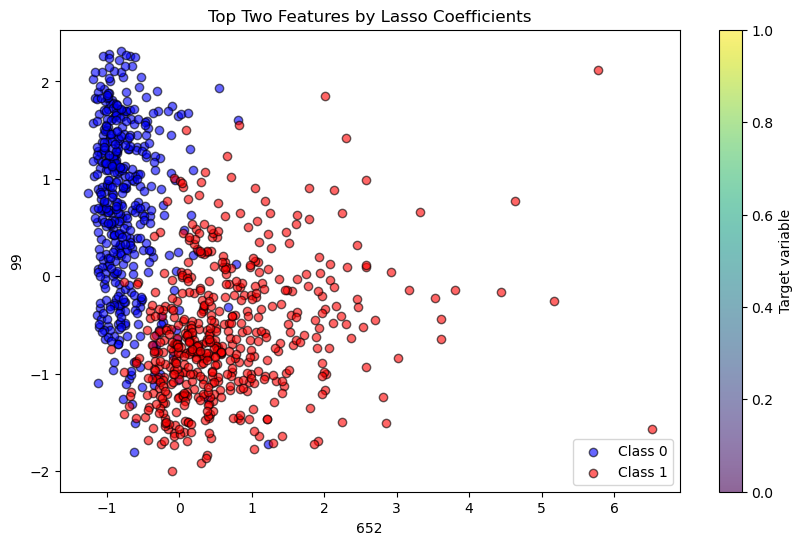

KS: 0.9401 (p-value: 9.793e-233)
ROC AUC: 0.9925
Kolmogorov-Smirnov Distance (Training): 0.9400821601340964
ROC AUC (Training): 0.9925091843913115
KS: 0.8755 (p-value: 2.907e-64)
ROC AUC: 0.9787
Kolmogorov-Smirnov Distance (Testing): 0.8755272613654117
ROC AUC (Testing): 0.9786752069989064
Decision Boundary Threshold: 0.5
Train Accuracy: 0.9678089304257529
Confusion Matrix (Training):
 [[421  21]
 [ 10 511]]
Test Accuracy: 0.9345794392523364
Confusion Matrix (Testing):
 [[133  15]
 [  6 167]]
Ratio of Correct Classifications (Training): 0.9678089304257529
Ratio of Correct Classifications (Testing): 0.9345794392523364


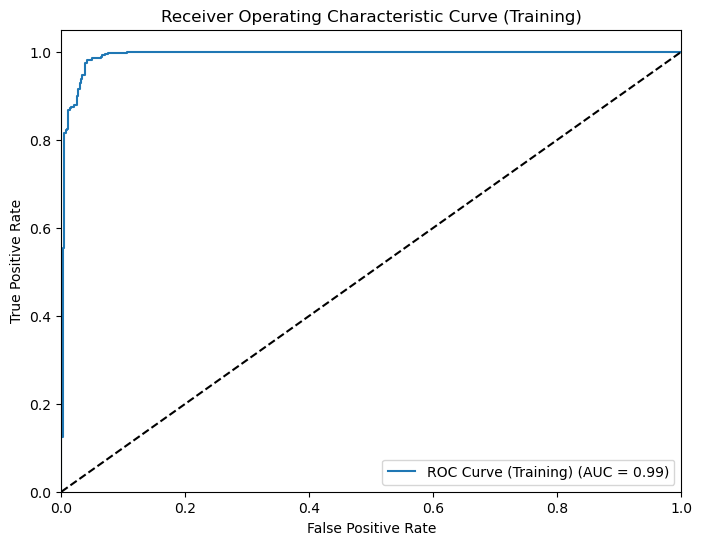

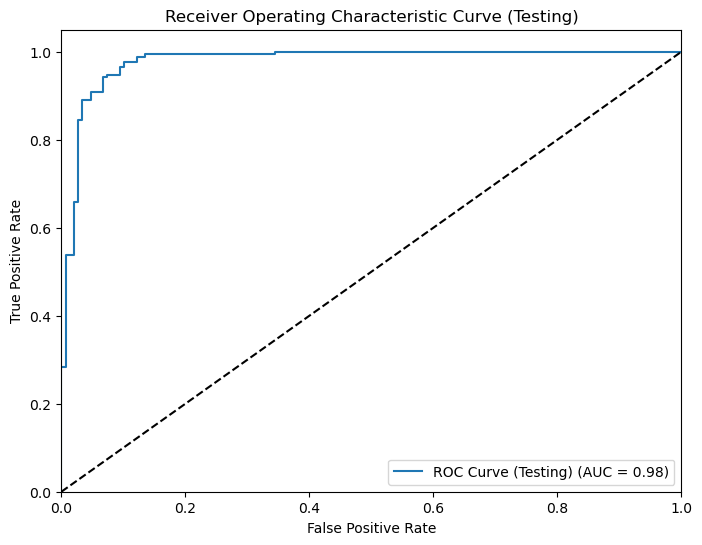

In [5]:
time1_h=9
time1_min_start=00
time1_min_finish=29
time2_h=16
time2_min_start=30
time2_min_finish=59
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (966, 2802)
Test data shape: (322, 2802)


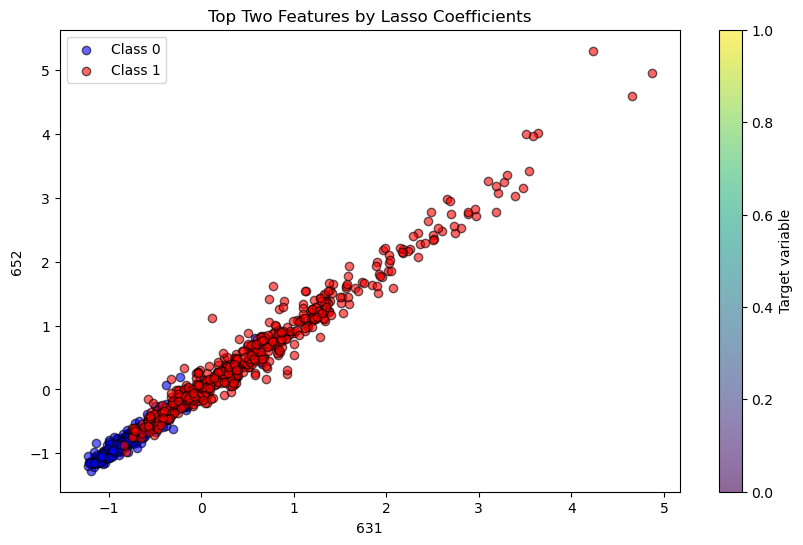

KS: 0.8904 (p-value: 7.326e-201)
ROC AUC: 0.9869
Kolmogorov-Smirnov Distance (Training): 0.8903578460156817
ROC AUC (Training): 0.9869045974232323
KS: 0.8354 (p-value: 2.288e-57)
ROC AUC: 0.9765
Kolmogorov-Smirnov Distance (Testing): 0.8354302578440509
ROC AUC (Testing): 0.9765455110282696
Decision Boundary Threshold: 0.5
Train Accuracy: 0.9399585921325052
Confusion Matrix (Training):
 [[419  23]
 [ 35 489]]
Test Accuracy: 0.906832298136646
Confusion Matrix (Testing):
 [[136  12]
 [ 18 156]]
Ratio of Correct Classifications (Training): 0.9399585921325052
Ratio of Correct Classifications (Testing): 0.906832298136646


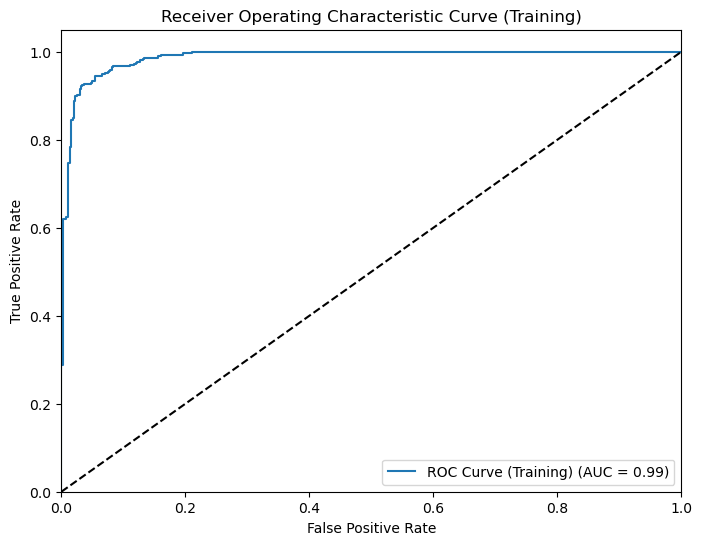

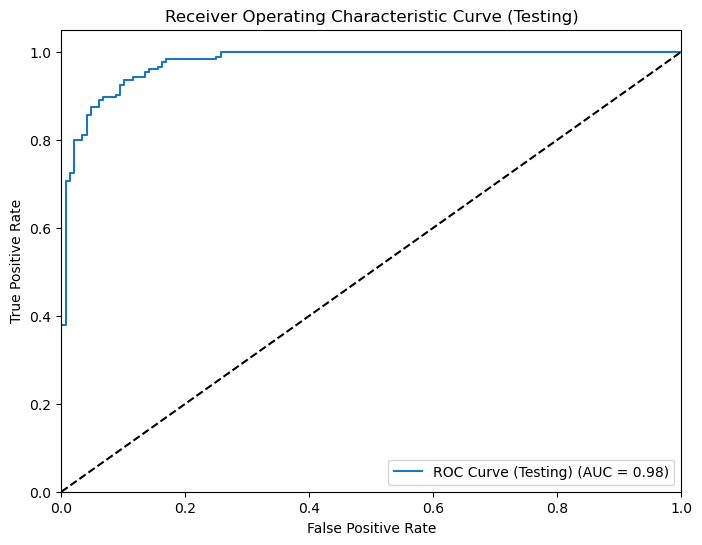

In [6]:
time1_h=10
time1_min_start=30
time1_min_finish=59
time2_h=16
time2_min_start=30
time2_min_finish=59
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (962, 2802)
Test data shape: (321, 2802)


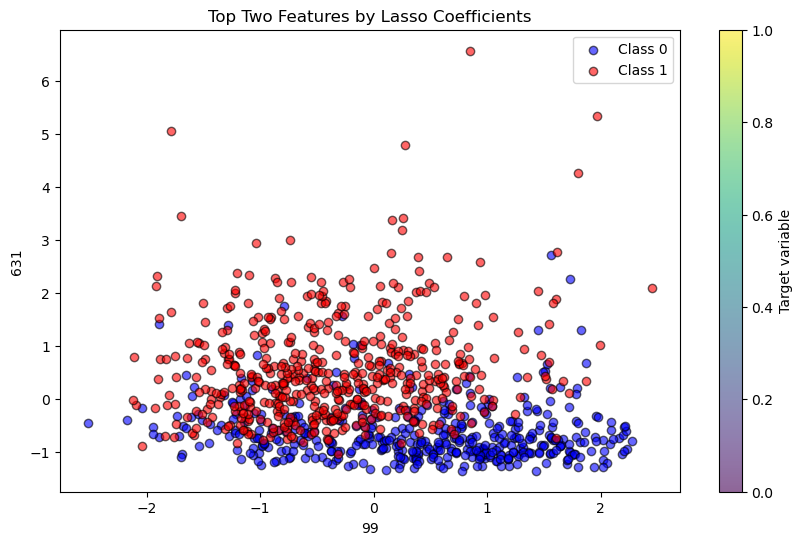

KS: 0.8122 (p-value: 4.639e-159)
ROC AUC: 0.9681
Kolmogorov-Smirnov Distance (Training): 0.8122171945701357
ROC AUC (Training): 0.9680821441002436
KS: 0.7521 (p-value: 1.122e-44)
ROC AUC: 0.9404
Kolmogorov-Smirnov Distance (Testing): 0.7521090454616466
ROC AUC (Testing): 0.940438993907202
Decision Boundary Threshold: 0.5
Train Accuracy: 0.9043659043659044
Confusion Matrix (Training):
 [[389  53]
 [ 39 481]]
Test Accuracy: 0.8660436137071651
Confusion Matrix (Testing):
 [[128  20]
 [ 23 150]]
Ratio of Correct Classifications (Training): 0.9043659043659044
Ratio of Correct Classifications (Testing): 0.8660436137071651


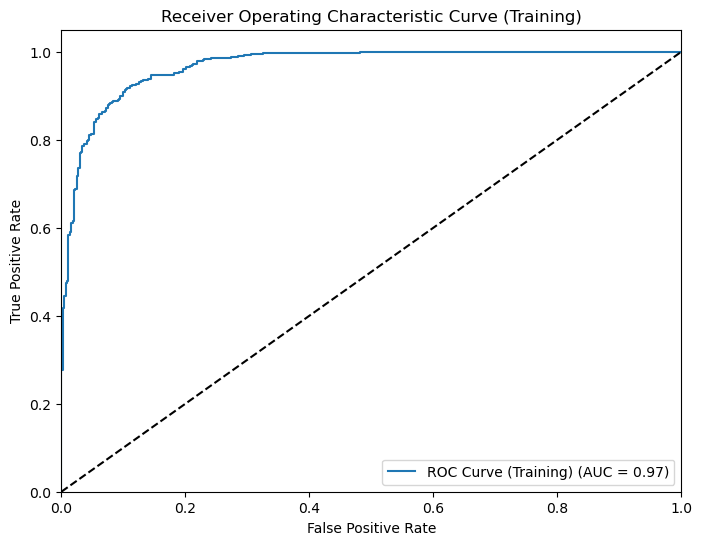

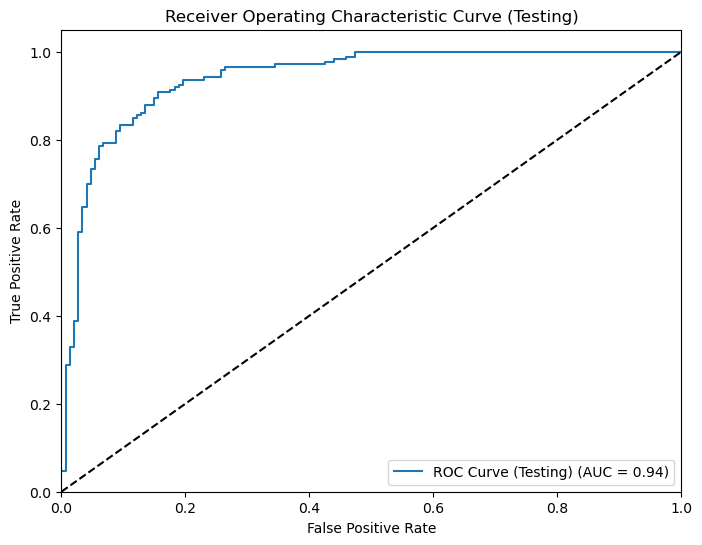

In [7]:
time1_h=12
time1_min_start=00
time1_min_finish=29
time2_h=16
time2_min_start=30
time2_min_finish=59
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (944, 2802)
Test data shape: (315, 2802)


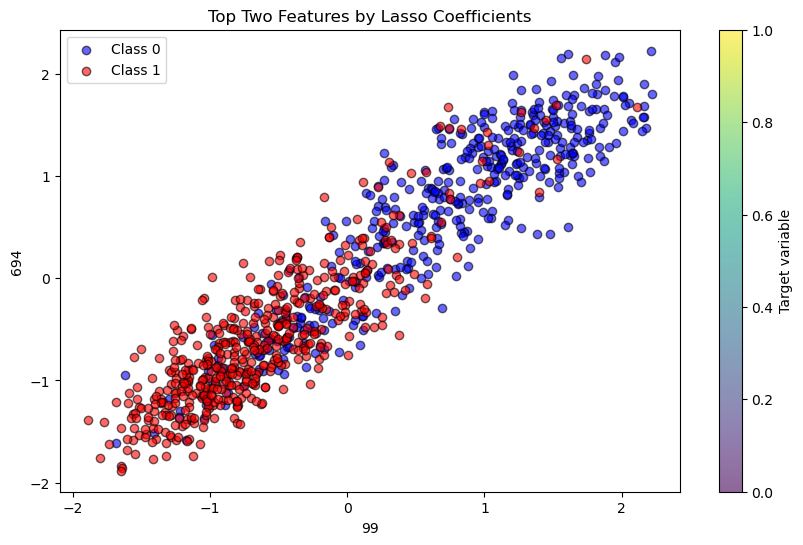

KS: 0.8029 (p-value: 3.142e-152)
ROC AUC: 0.9627
Kolmogorov-Smirnov Distance (Training): 0.8029150366858359
ROC AUC (Training): 0.9626651763984786
KS: 0.7602 (p-value: 4.751e-45)
ROC AUC: 0.9326
Kolmogorov-Smirnov Distance (Testing): 0.7601553649457841
ROC AUC (Testing): 0.9325942709176241
Decision Boundary Threshold: 0.5
Train Accuracy: 0.8983050847457628
Confusion Matrix (Training):
 [[381  61]
 [ 35 467]]
Test Accuracy: 0.8539682539682539
Confusion Matrix (Testing):
 [[118  30]
 [ 16 151]]
Ratio of Correct Classifications (Training): 0.8983050847457628
Ratio of Correct Classifications (Testing): 0.8539682539682539


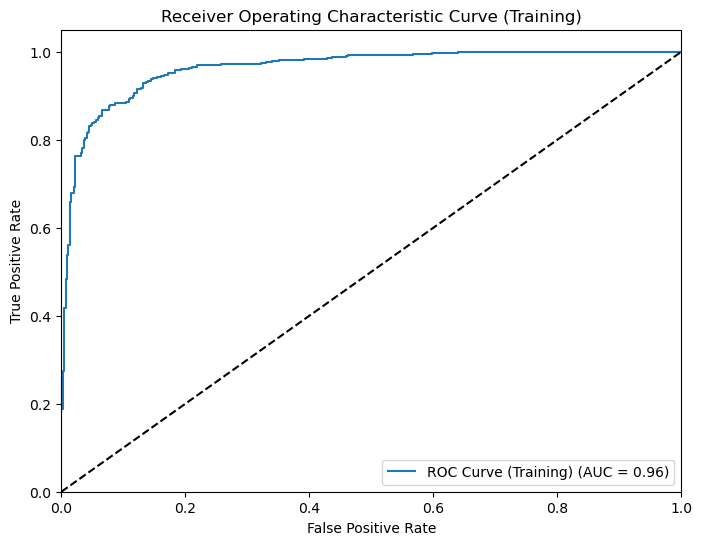

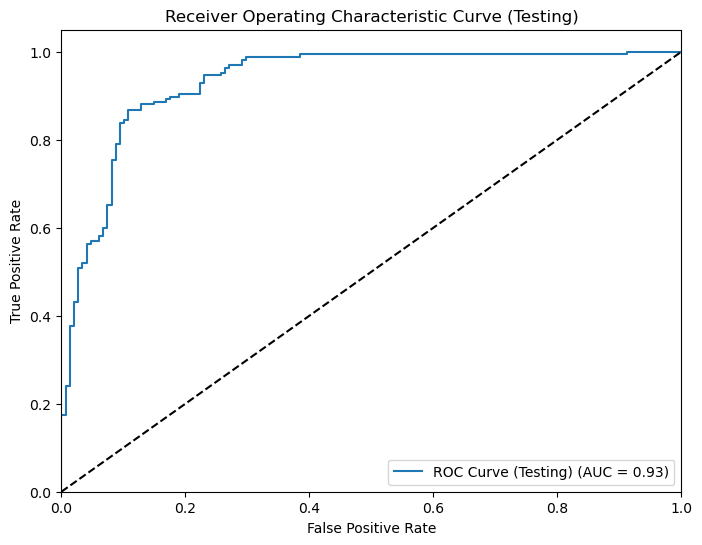

In [8]:
time1_h=14
time1_min_start=30
time1_min_finish=59
time2_h=16
time2_min_start=30
time2_min_finish=59
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (944, 2802)
Test data shape: (315, 2802)


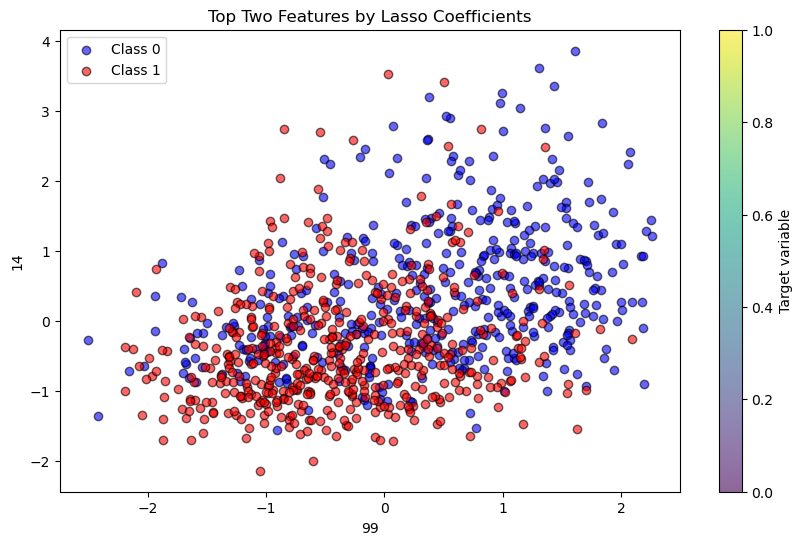

KS: 0.6638 (p-value: 9.816e-99)
ROC AUC: 0.9060
Kolmogorov-Smirnov Distance (Training): 0.6638243406464639
ROC AUC (Training): 0.9060364875340268
KS: 0.5472 (p-value: 3.943e-22)
ROC AUC: 0.8327
Kolmogorov-Smirnov Distance (Testing): 0.5471759184334035
ROC AUC (Testing): 0.8326590063117009
Decision Boundary Threshold: 0.5
Train Accuracy: 0.8347457627118644
Confusion Matrix (Training):
 [[348  94]
 [ 62 440]]
Test Accuracy: 0.7555555555555555
Confusion Matrix (Testing):
 [[103  45]
 [ 32 135]]
Ratio of Correct Classifications (Training): 0.8347457627118644
Ratio of Correct Classifications (Testing): 0.7555555555555555


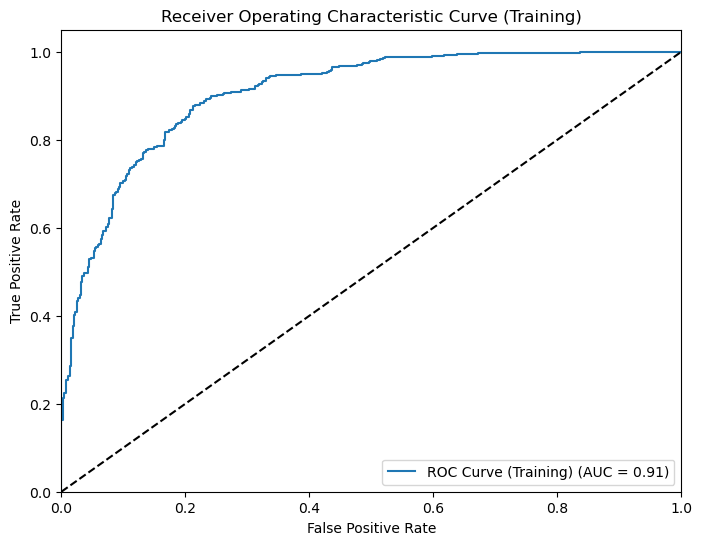

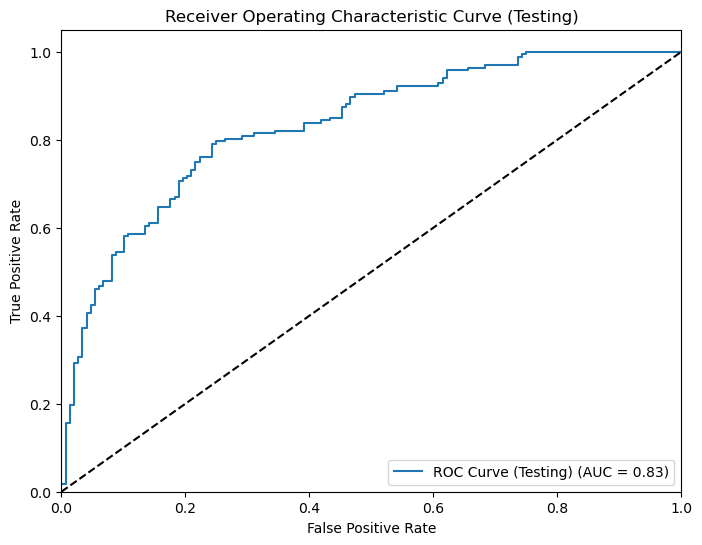

In [9]:
time1_h=15
time1_min_start=0
time1_min_finish=29
time2_h=16
time2_min_start=30
time2_min_finish=59
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (904, 2802)
Test data shape: (302, 2802)


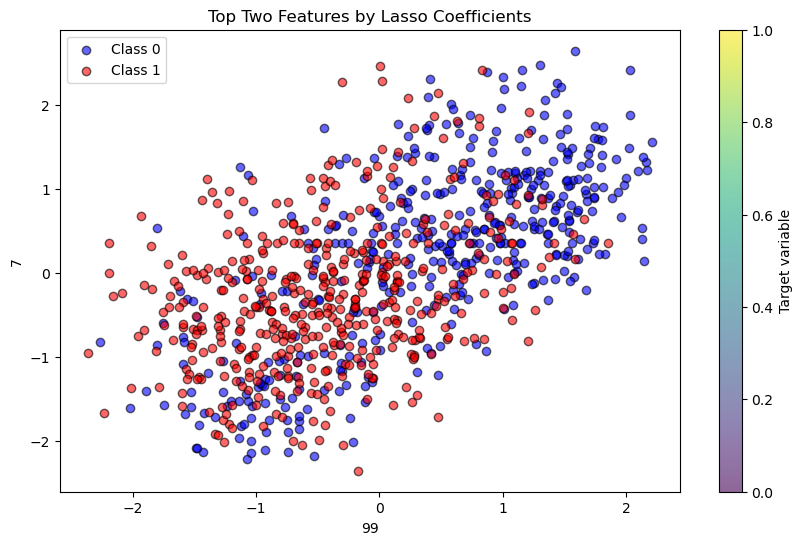

KS: 0.6713 (p-value: 2.746e-97)
ROC AUC: 0.9068
Kolmogorov-Smirnov Distance (Training): 0.6713286713286714
ROC AUC (Training): 0.9068333627157158
KS: 0.5641 (p-value: 9.665e-23)
ROC AUC: 0.8506
Kolmogorov-Smirnov Distance (Testing): 0.564057564057564
ROC AUC (Testing): 0.8506054756054756
Decision Boundary Threshold: 0.5
Train Accuracy: 0.831858407079646
Confusion Matrix (Training):
 [[349  93]
 [ 59 403]]
Test Accuracy: 0.7582781456953642
Confusion Matrix (Testing):
 [[104  44]
 [ 29 125]]
Ratio of Correct Classifications (Training): 0.831858407079646
Ratio of Correct Classifications (Testing): 0.7582781456953642


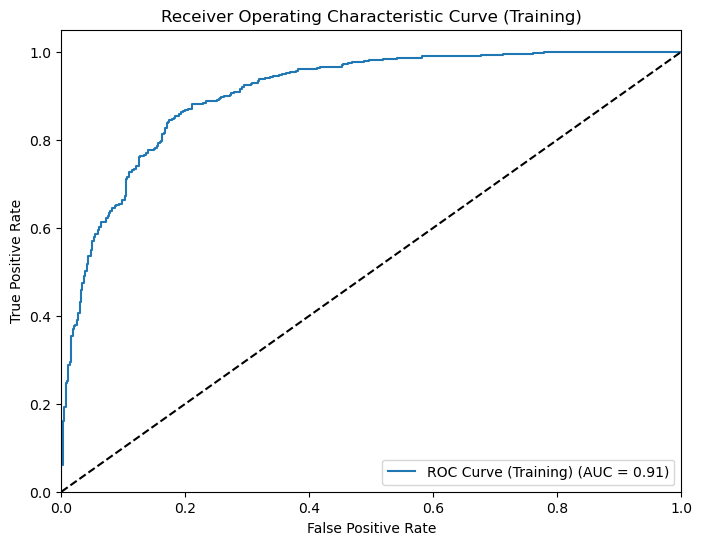

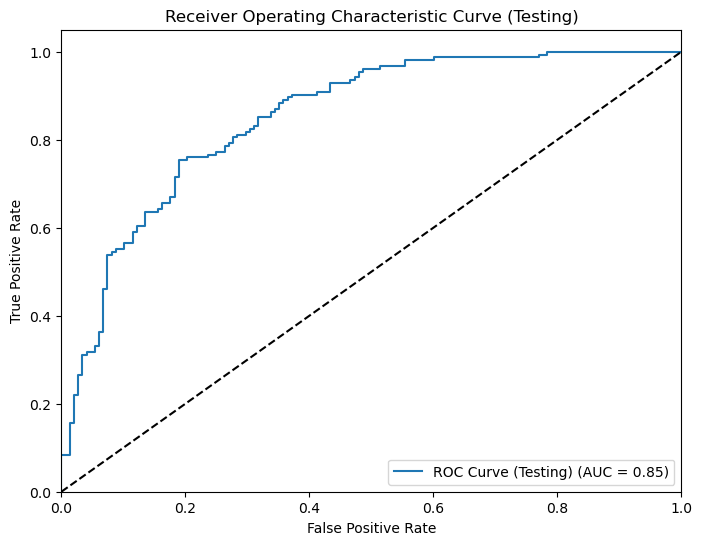

In [10]:
time1_h=16
time1_min_start=0
time1_min_finish=29
time2_h=16
time2_min_start=30
time2_min_finish=59
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

## Experiment 2: comparing versus 11:00 - 11:20 A.M.

Train data shape: (1041, 2802)
Test data shape: (348, 2802)


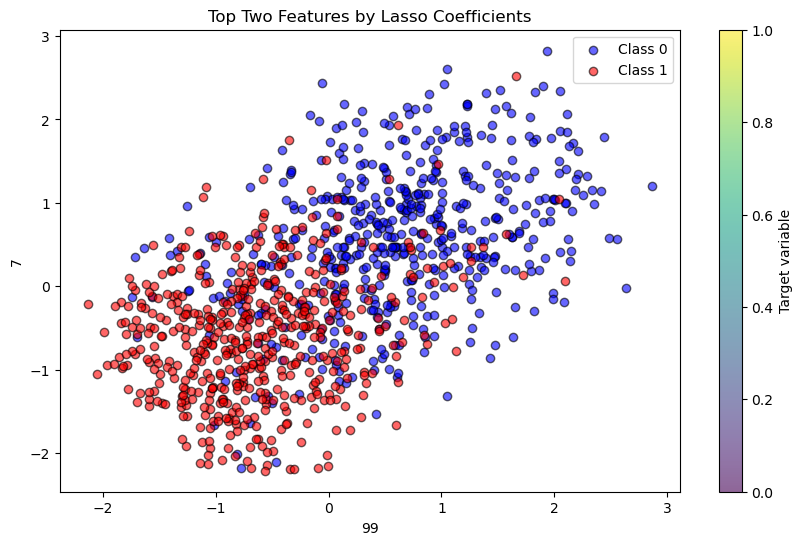

KS: 0.7330 (p-value: 1.000e-136)
ROC AUC: 0.9343
Kolmogorov-Smirnov Distance (Training): 0.7330134357005759
ROC AUC (Training): 0.9343311678724346
KS: 0.7184 (p-value: 1.331e-43)
ROC AUC: 0.9075
Kolmogorov-Smirnov Distance (Testing): 0.7183908045977011
ROC AUC (Testing): 0.9074844761527282
Decision Boundary Threshold: 0.5
Train Accuracy: 0.866474543707973
Confusion Matrix (Training):
 [[450  71]
 [ 68 452]]
Test Accuracy: 0.8419540229885057
Confusion Matrix (Testing):
 [[145  29]
 [ 26 148]]
Ratio of Correct Classifications (Training): 0.866474543707973
Ratio of Correct Classifications (Testing): 0.8419540229885057


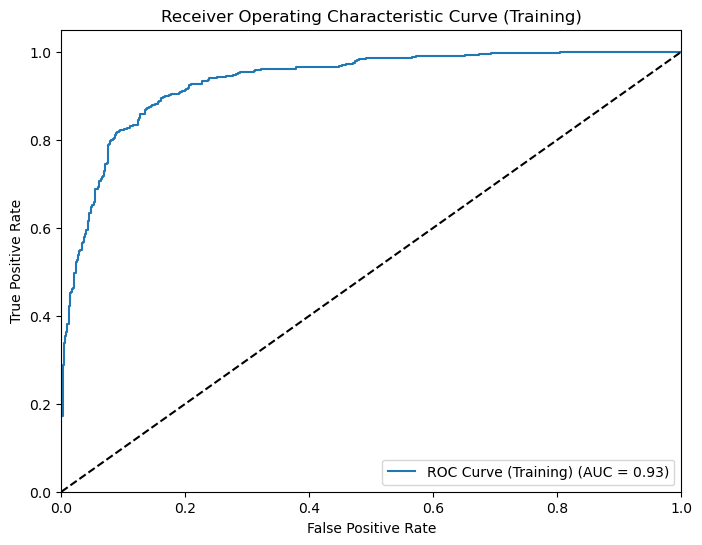

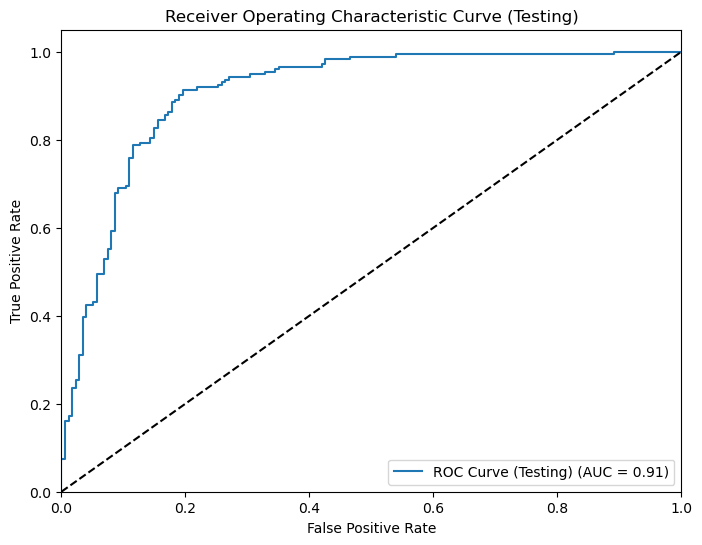

In [11]:
time1_h=9
time1_min_start=0
time1_min_finish=29
time2_h=11
time2_min_start=0
time2_min_finish=29
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (1047, 2802)
Test data shape: (350, 2802)


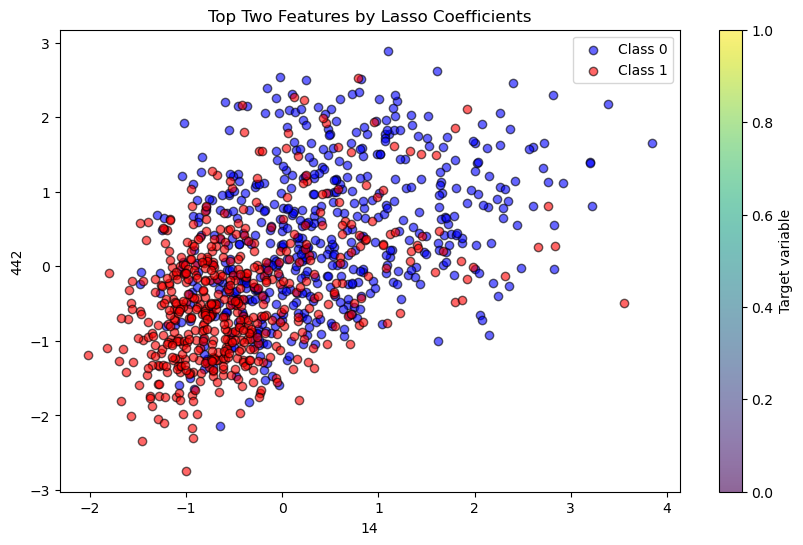

KS: 0.5683 (p-value: 1.436e-78)
ROC AUC: 0.8631
Kolmogorov-Smirnov Distance (Training): 0.568316997876269
ROC AUC (Training): 0.8631215197448603
KS: 0.4515 (p-value: 1.249e-16)
ROC AUC: 0.7967
Kolmogorov-Smirnov Distance (Testing): 0.4515412748171369
ROC AUC (Testing): 0.7966627481713688
Decision Boundary Threshold: 0.5
Train Accuracy: 0.775549188156638
Confusion Matrix (Training):
 [[394 127]
 [108 418]]
Test Accuracy: 0.7085714285714285
Confusion Matrix (Testing):
 [[118  56]
 [ 46 130]]
Ratio of Correct Classifications (Training): 0.775549188156638
Ratio of Correct Classifications (Testing): 0.7085714285714285


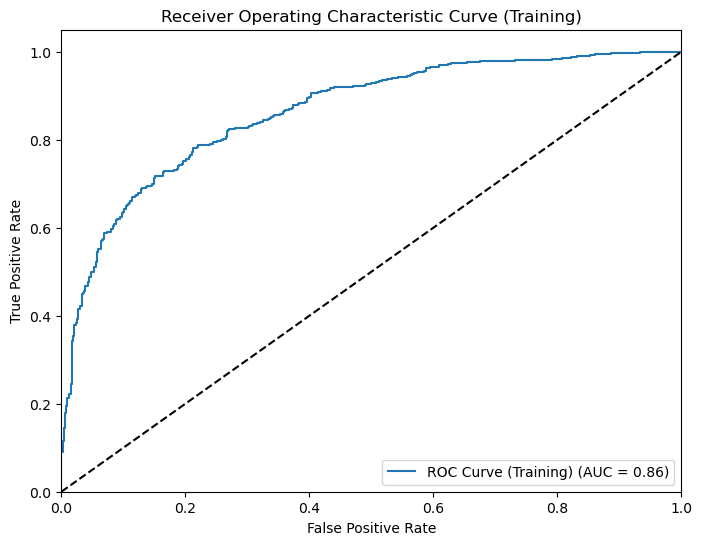

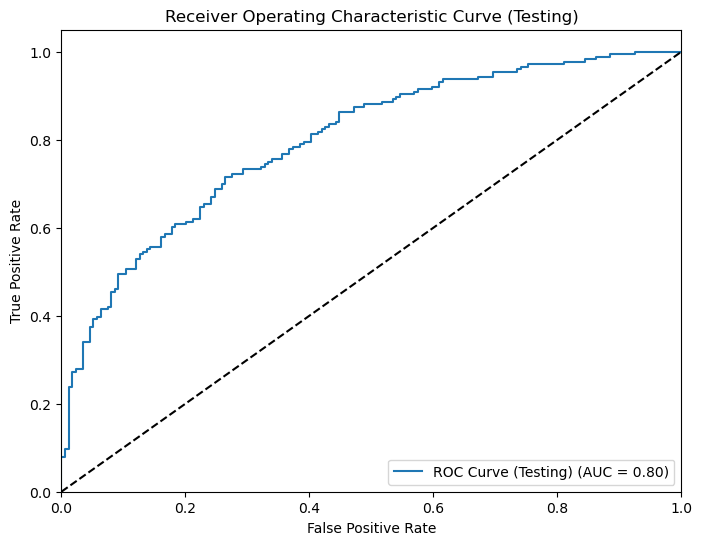

In [12]:
time1_h=10
time1_min_start=0
time1_min_finish=29
time2_h=11
time2_min_start=0
time2_min_finish=29
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (1036, 2802)
Test data shape: (346, 2802)


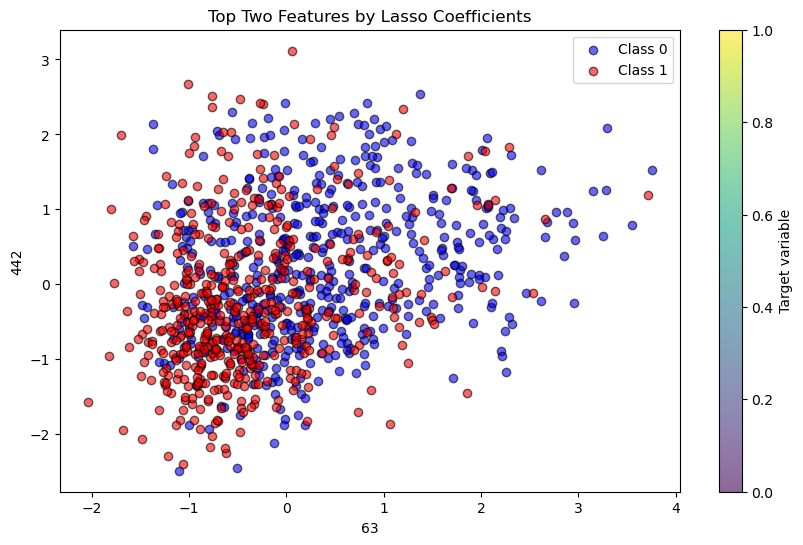

KS: 0.5577 (p-value: 1.313e-74)
ROC AUC: 0.8554
Kolmogorov-Smirnov Distance (Training): 0.5576654305573673
ROC AUC (Training): 0.8554460242625274
KS: 0.4753 (p-value: 2.192e-18)
ROC AUC: 0.8059
Kolmogorov-Smirnov Distance (Testing): 0.475273990911521
ROC AUC (Testing): 0.8058674151296444
Decision Boundary Threshold: 0.5
Train Accuracy: 0.7644787644787645
Confusion Matrix (Training):
 [[392 129]
 [115 400]]
Test Accuracy: 0.7283236994219653
Confusion Matrix (Testing):
 [[114  60]
 [ 34 138]]
Ratio of Correct Classifications (Training): 0.7644787644787645
Ratio of Correct Classifications (Testing): 0.7283236994219653


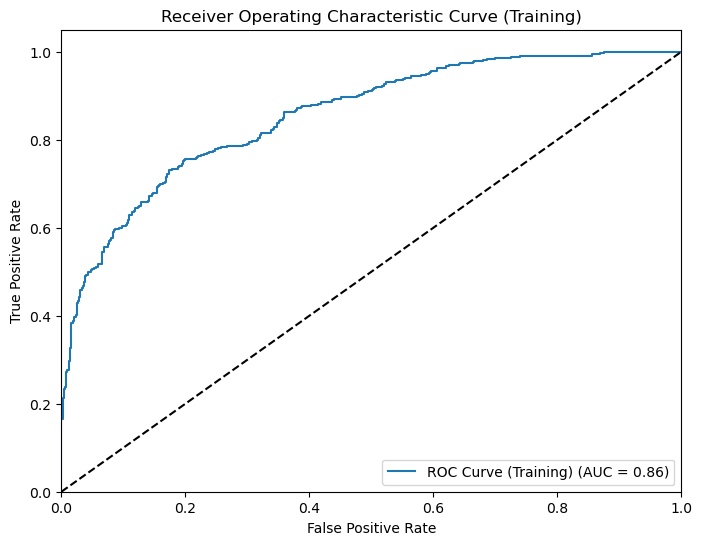

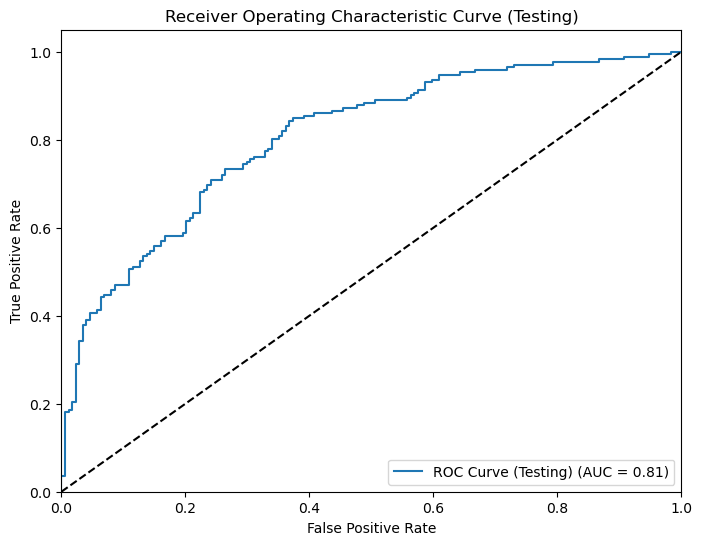

In [13]:
time1_h=13
time1_min_start=0
time1_min_finish=29
time2_h=11
time2_min_start=0
time2_min_finish=29
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (1022, 2802)
Test data shape: (341, 2802)


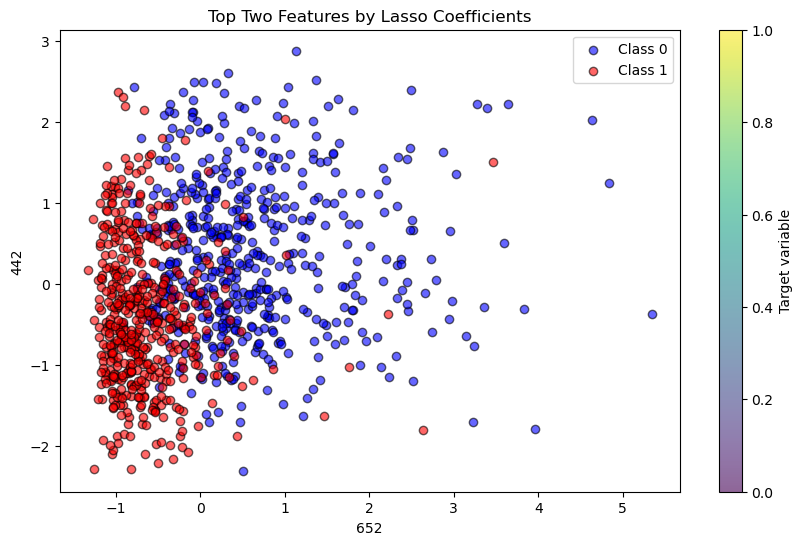

KS: 0.8412 (p-value: 6.302e-185)
ROC AUC: 0.9705
Kolmogorov-Smirnov Distance (Training): 0.8411583742304259
ROC AUC (Training): 0.9705234444738163
KS: 0.8015 (p-value: 2.020e-55)
ROC AUC: 0.9522
Kolmogorov-Smirnov Distance (Testing): 0.8014660334503407
ROC AUC (Testing): 0.9521990501755111
Decision Boundary Threshold: 0.5
Train Accuracy: 0.9021526418786693
Confusion Matrix (Training):
 [[457  64]
 [ 36 465]]
Test Accuracy: 0.8944281524926686
Confusion Matrix (Testing):
 [[150  24]
 [ 12 155]]
Ratio of Correct Classifications (Training): 0.9021526418786693
Ratio of Correct Classifications (Testing): 0.8944281524926686


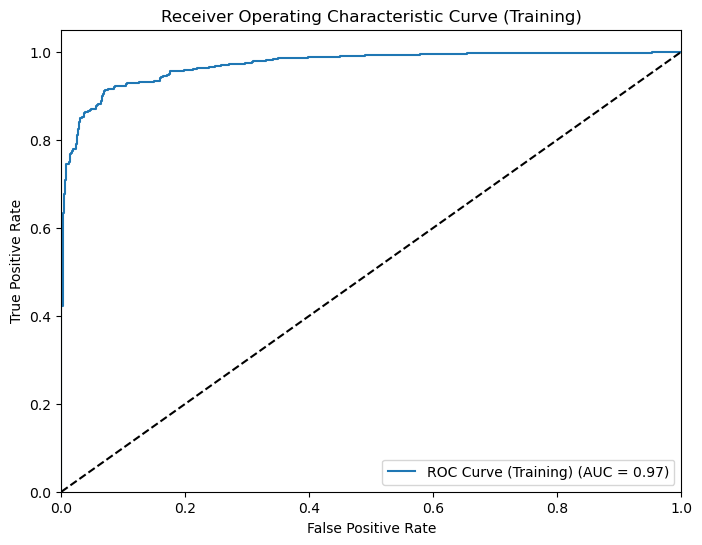

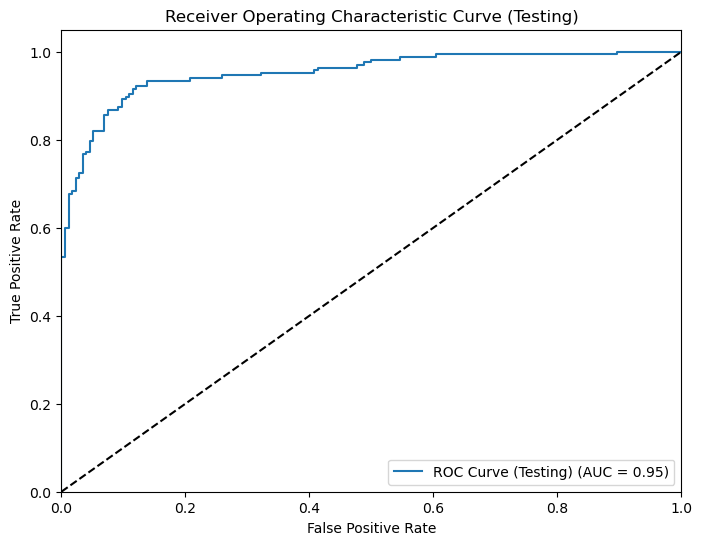

In [14]:
time1_h=15
time1_min_start=0
time1_min_finish=29
time2_h=11
time2_min_start=0
time2_min_finish=29
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (963, 2802)
Test data shape: (322, 2802)


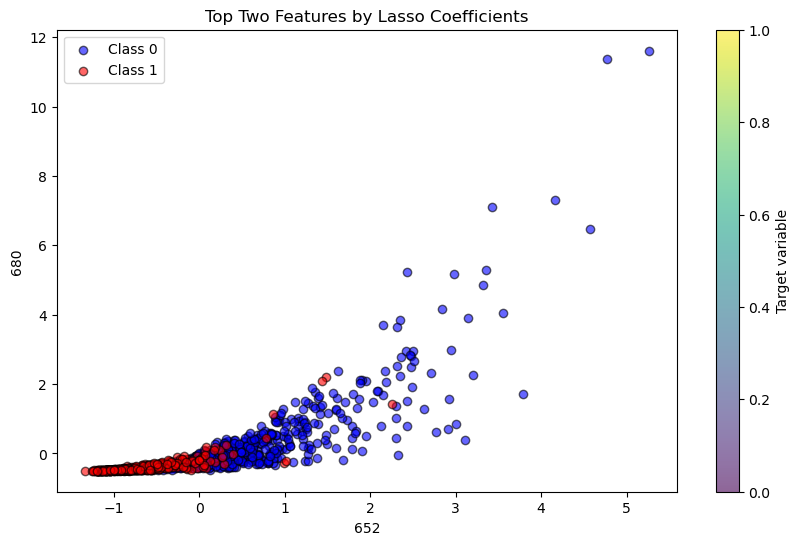

KS: 0.8784 (p-value: 1.925e-193)
ROC AUC: 0.9813
Kolmogorov-Smirnov Distance (Training): 0.8784490320563483
ROC AUC (Training): 0.981279474730982
KS: 0.9010 (p-value: 2.153e-69)
ROC AUC: 0.9801
Kolmogorov-Smirnov Distance (Testing): 0.9009785647716683
ROC AUC (Testing): 0.9800792171481827
Decision Boundary Threshold: 0.5
Train Accuracy: 0.936656282450675
Confusion Matrix (Training):
 [[488  33]
 [ 28 414]]
Test Accuracy: 0.9409937888198758
Confusion Matrix (Testing):
 [[162  12]
 [  7 141]]
Ratio of Correct Classifications (Training): 0.936656282450675
Ratio of Correct Classifications (Testing): 0.9409937888198758


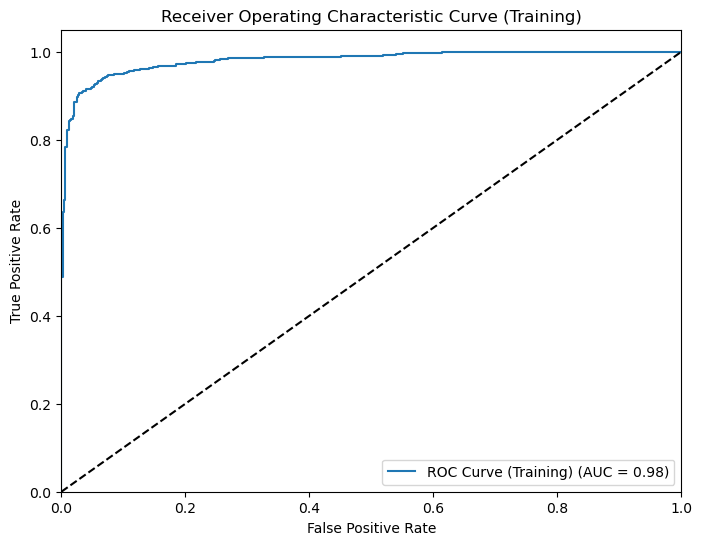

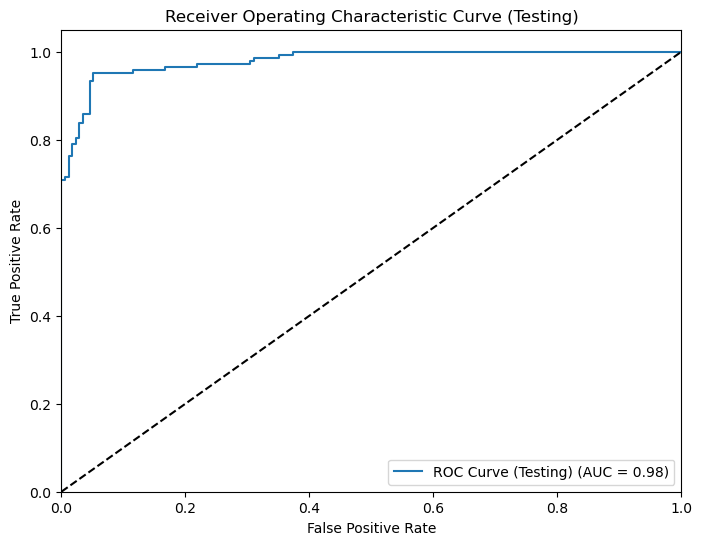

In [15]:
time1_h=16
time1_min_start=30
time1_min_finish=59
time2_h=11
time2_min_start=0
time2_min_finish=29
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)

Train data shape: (1042, 2802)
Test data shape: (348, 2802)


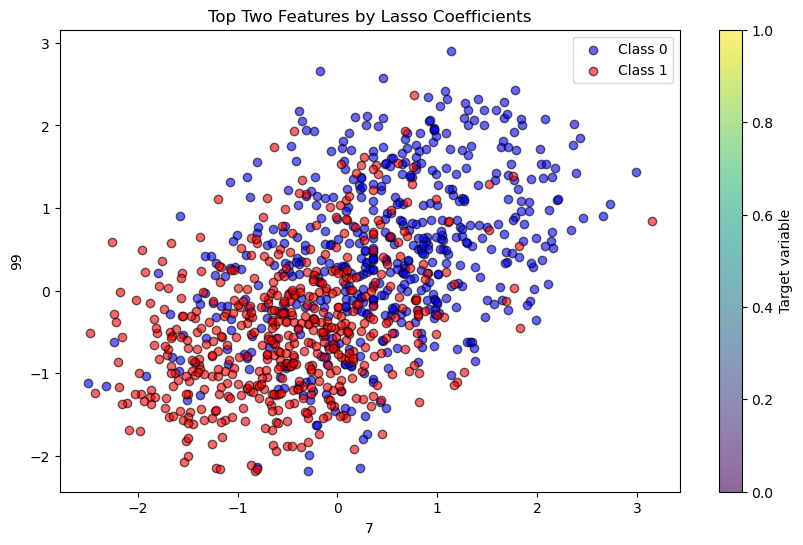

KS: 0.6238 (p-value: 3.276e-95)
ROC AUC: 0.8906
Kolmogorov-Smirnov Distance (Training): 0.6238003838771593
ROC AUC (Training): 0.8905618532204052
KS: 0.5402 (p-value: 1.258e-23)
ROC AUC: 0.8248
Kolmogorov-Smirnov Distance (Testing): 0.5402298850574713
ROC AUC (Testing): 0.8248447615272824
Decision Boundary Threshold: 0.5
Train Accuracy: 0.8061420345489443
Confusion Matrix (Training):
 [[411 110]
 [ 92 429]]
Test Accuracy: 0.7385057471264368
Confusion Matrix (Testing):
 [[129  45]
 [ 46 128]]
Ratio of Correct Classifications (Training): 0.8061420345489443
Ratio of Correct Classifications (Testing): 0.7385057471264368


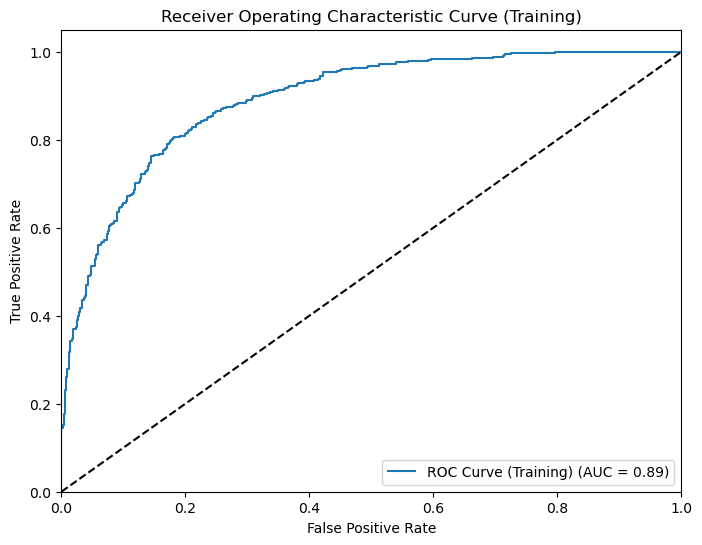

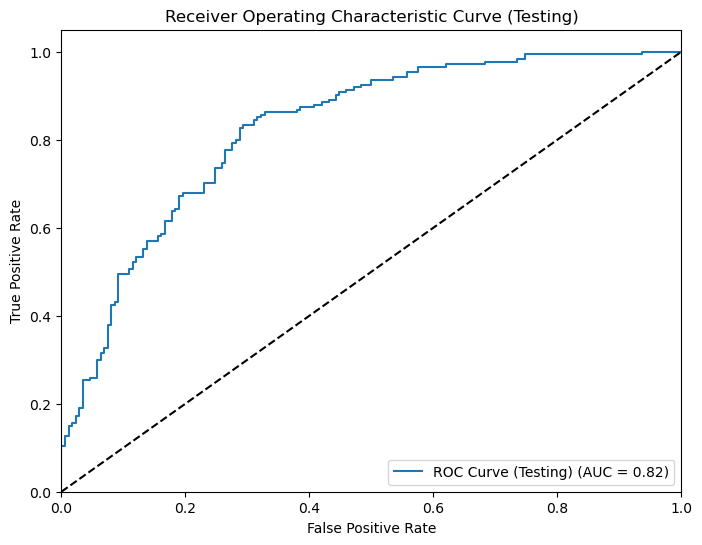

In [16]:
time1_h=11
time1_min_start=30
time1_min_finish=59
time2_h=11
time2_min_start=0
time2_min_finish=29
full_experiment(time1_h, time1_min_start, time1_min_finish, time2_h, time2_min_start, time2_min_finish, df_combined)